In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

Matplotlib created a temporary cache directory at /tmp/matplotlib-u0ltg7j6 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
sc = SparkSession.builder \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "2g") \
    .config('spark.executor.instances', 3) \
    .appName("Steam Reviews") \
    .getOrCreate()

In [3]:
Steam_data = sc.read.csv("kaggle/all_reviews.csv",header=True, inferSchema=True)

In [4]:
Steam_data = Steam_data.filter(Steam_data.language == 'english') ## English Only Reviews, don't have to do this if we are not looking at text data. Should do this for NLP
Steam_data = Steam_data.filter((Steam_data.voted_up == '0') | (Steam_data.voted_up == '1')) ## There's reviews in some of these

In [5]:
## Selecting only studied columns, limiting columns
Select_Steam = Steam_data.select(
    'author_playtime_forever',
    'author_playtime_at_review',
    'author_playtime_last_two_weeks',
    'voted_up'
).cache()

In [9]:
assembler = VectorAssembler(inputCols=Select_Steam.columns[:1], outputCol="features")
df = assembler.transform(Select_Steam)
df = df.withColumn('voted_up', df['voted_up'].cast('float'))

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

log_reg = LogisticRegression(featuresCol="features", labelCol="voted_up")

log_reg_model = log_reg.fit(train_data)


In [22]:
assembler = VectorAssembler(inputCols=Select_Steam.columns[:1], outputCol="features")
df = assembler.transform(Select_Steam)
df = df.withColumn('voted_up', df['voted_up'].cast('float'))

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
param = [0.01, 0.1, 1, 10, 100]

train_error=[]
test_error=[]

evaluator = MulticlassClassificationEvaluator(labelCol='voted_up', predictionCol='prediction', metricName='logLoss')

for i in param:
    log_reg = LogisticRegression(featuresCol="features", labelCol="voted_up", regParam=1/i)
    log_reg_model = log_reg.fit(train_data)
    test_predictions = log_reg_model.transform(test_data)
    train_predictions = log_reg_model.transform(train_data)
    test_errors=evaluator.evaluate(test_predictions)
    train_errors=evaluator.evaluate(train_predictions)
    test_error.append(test_errors)
    train_error.append(train_errors)

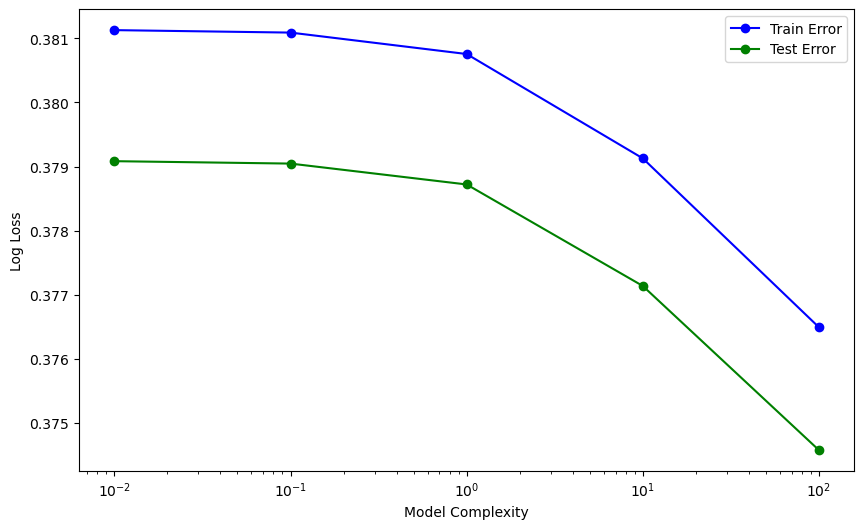

In [25]:
plt.figure(figsize=(10,6))
plt.plot(param, train_error, label="Train Error", color='blue', marker='o')
plt.plot(param, test_error, label="Test Error", color='green', marker='o')
plt.xlabel("Model Complexity")
plt.ylabel("Log Loss")
plt.legend()
plt.xscale('log')

In [16]:
assembler = VectorAssembler(inputCols=Select_Steam.columns[:1], outputCol="features")
df = assembler.transform(Select_Steam)
df = df.withColumn('voted_up', df['voted_up'].cast('float'))

train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)
param = [0.01, 0.1, 1, 10, 100]

train_error=[]
test_error=[]

evaluator = MulticlassClassificationEvaluator(labelCol='voted_up', predictionCol='prediction', metricName='accuracy')

for reg_param in param:
    log_reg = LogisticRegression(featuresCol="features", labelCol="voted_up", regParam=1/reg_param)
    log_reg_model = log_reg.fit(train_data)
    test_predictions = log_reg_model.transform(test_data)
    train_predictions = log_reg_model.transform(train_data)
    
    train_acc = evaluator.evaluate(train_predictions)
    test_acc = evaluator.evaluate(test_predictions)
    train_errors=1-train_acc
    test_errors=1-test_acc
    
    test_error.append(test_errors)
    train_error.append(train_errors)

In [18]:
train_error

[0.12725291919834458,
 0.12725291919834458,
 0.12725291919834458,
 0.12725291919834458,
 0.12725291919834458]

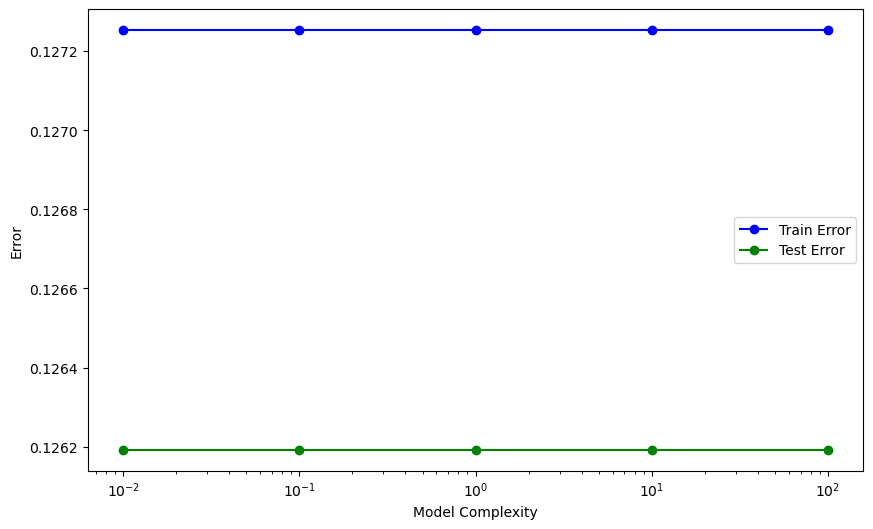

In [12]:
plt.figure(figsize=(10,6))
plt.plot(param, train_error, label="Train Error", color='blue', marker='o')
plt.plot(param, test_error, label="Test Error", color='green', marker='o')
plt.xlabel("Model Complexity")
plt.ylabel("Error")
plt.legend()
plt.xticks(param)
plt.xscale('log')